# Volume Analysis for SPY etf  0dte 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from config import MONGO_URI
import datetime
import warnings
warnings.filterwarnings("ignore")

client = MongoClient(MONGO_URI)
db = client['options_data']
collection = db['snapshots']

Next I preprocess the data snapshots from mongo DB

In [57]:
snapshots = list(collection.find())
df = pd.DataFrame(snapshots)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

call_data = df['options_data'].apply(lambda x: [d for d in x if d['Type'] == 'call'])
put_data = df['options_data'].apply(lambda x: [d for d in x if d['Type'] == 'put'])


Next is to plot histograms for call and put volumes for each strike price and each type of options, for each snapshot saved into the DB

In [59]:
from ipywidgets import interact, Dropdown, fixed, IntSlider, Checkbox
import pytz

dates = df.index.date
unique_dates = sorted(set(dates))

def snapshot_by_date(date):
    return df[df.index.date == date]
    
def plot_histogram(date, snapshot_idx, show_line=False):
    daily_data = snapshot_by_date(date)
    call_volume = pd.DataFrame(call_data[snapshot_idx])
    put_volume = pd.DataFrame(put_data[snapshot_idx])
    underlying_price = daily_data['underlying_price'].iloc[snapshot_idx]
    pcr = daily_data['put_call_ratio'].iloc[snapshot_idx]
    snapshot_timestamp = daily_data.index[snapshot_idx]
    snapshot_timestamp_pst = snapshot_timestamp.tz_localize('America/Los_Angeles')
    max_call_volume = call_volume['Volume'].max()
    max_call_strike = call_volume[call_volume['Volume'] == max_call_volume]['Strike Price'].iloc[0]
    
    max_put_volume = put_volume['Volume'].max()
    max_put_strike = put_volume[put_volume['Volume'] == max_put_volume]['Strike Price'].iloc[0]
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle(
        f"Volume Histograms for {date.strftime('%Y-%m-%d')}'s 0dte options\n"
        f"Time (PST): {snapshot_timestamp_pst.strftime('%H:%M:%S')}  | Underlying Price: ${underlying_price:.2f} | PCR: {pcr:.2f}",
        fontsize=12, fontweight='bold'
    )

    call_color = '#00FF00'
    call_highlight = '#006600'
    put_color = '#FF0000'
    put_highlight = '#990000'

    if show_line:
        axs[0].plot(call_volume['Strike Price'], call_volume['Volume'], color=call_color, marker='o')
        axs[0].plot(max_call_strike, max_call_volume, 'o', color=call_highlight, markersize=10, label='Max Volume')
    else:
        colors = [call_highlight if strike == max_call_strike else call_color for strike in call_volume['Strike Price']]
        axs[0].bar(call_volume['Strike Price'], call_volume['Volume'], color=colors)
    
    axs[0].set_title('Call Volume')
    axs[0].set_xlabel('Strike Price')
    axs[0].set_ylabel('Volume')
    axs[0].set_xticks(call_volume['Strike Price'])
    axs[0].axvline(x=underlying_price, color='blue', linestyle='--', label=f'Underlying Price: {underlying_price}')
    axs[0].legend()

    if show_line:
        axs[1].plot(put_volume['Strike Price'], put_volume['Volume'], color=put_color, marker='o')
        axs[1].plot(max_put_strike, max_put_volume, 'o', color=put_highlight, markersize=10, label='Max Volume')
    else:
        colors = [put_highlight if strike == max_put_strike else put_color for strike in put_volume['Strike Price']]
        axs[1].bar(put_volume['Strike Price'], put_volume['Volume'], color=colors)
    
    axs[1].set_title('Put Volume')
    axs[1].set_xlabel('Strike Price')
    axs[1].set_ylabel('Volume')
    axs[1].set_xticks(put_volume['Strike Price'])
    axs[1].axvline(x=underlying_price, color='blue', linestyle='--', label=f'Underlying Price: {underlying_price}')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def update_plot(date):
    daily_data = snapshot_by_date(date)
    max_snapshot_idx = len(daily_data) - 1
    slider = IntSlider(value=0, min=0, max=max_snapshot_idx, step=1, description="Snapshot")
    toggle = Checkbox(value=False, description="Show Line Graph")
    interact(plot_histogram, date=fixed(date), snapshot_idx=slider, show_line=toggle)

interact(update_plot, date=Dropdown(options=unique_dates, description='Select Date'))

interactive(children=(Dropdown(description='Select Date', options=(datetime.date(2024, 11, 12), datetime.date(…

<function __main__.update_plot(date)>

## Volume Analysis on Time of Day

In [7]:
call_volume_hour = call_data.groupby("hour")['volume'].mean()
put_volume_hour = put_data.groupby("hour")['volume'].mean()

volume_by_hour = pd.DataFrame({
    "call volume": call_volume_hour,
    "put volume": put_vokume_hour}).fillna(0)

plt.figure(figsize=(12, 6))
plt.plot(volume_by_hour.index, volume_by_hour['Call Volume'], label='Average Call Volume', color='blue', marker='o')
plt.plot(volume_by_hour.index, volume_by_hour['Put Volume'], label='Average Put Volume', color='red', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Volume')
plt.title('Average Call and Put Volume by Time of Day')
plt.legend()
plt.xticks(range(6, 13))  # Typical US stock market hours (9 AM - 4 PM)
plt.grid()
plt.show()

volume_by_hour_heatmap = volume_by_hour.T  # Transpose for better visualization

plt.figure(figsize=(12, 6))
sns.heatmap(volume_by_hour_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Average Volume'})
plt.title('Heatmap of Average Call and Put Volume by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Type of Option')
plt.xticks(range(8, 17), [f"{h}:00" for h in range(8, 17)])  # Adjust hours to match your data if needed
plt.show()

KeyError: 'hour'

In [6]:
def plot_deltas_over_time(call_df, put_df):
    # Convert timestamp to datetime for plotting
    call_df['timestamp'] = pd.to_datetime(call_df['timestamp'])
    put_df['timestamp'] = pd.to_datetime(put_df['timestamp'])
    
    plt.figure(figsize=(14, 6))

    # Plot call deltas
    plt.subplot(1, 2, 1)
    plt.plot(call_df['timestamp'], call_df['delta'], label='Call Delta', color='blue', marker='o', linestyle='-')
    plt.title("Call Delta Over Time")
    plt.xlabel("Timestamp (PST)")
    plt.ylabel("Delta")
    plt.xticks(rotation=45)

    # Plot put deltas
    plt.subplot(1, 2, 2)
    plt.plot(put_df['timestamp'], put_df['delta'], label='Put Delta', color='red', marker='o', linestyle='-')
    plt.title("Put Delta Over Time")
    plt.xlabel("Timestamp (PST)")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_deltas_by_strike(call_df, put_df):
    # Plot delta by strike price for calls and puts
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(call_df['strike_price'], call_df['delta'], label='Call Delta', color='blue')
    plt.title("Call Delta by Strike Price")
    plt.xlabel("Strike Price")
    plt.ylabel("Delta")

    plt.subplot(1, 2, 2)
    plt.scatter(put_df['strike_price'], put_df['delta'], label='Put Delta', color='red')
    plt.title("Put Delta by Strike Price")
    plt.xlabel("Strike Price")

    plt.tight_layout()
    plt.show()



# Plot delta trends over time
plot_deltas_over_time(call_data, put_data)

# Plot delta by strike price
plot_deltas_by_strike(call_data, put_data)

KeyError: 'timestamp'

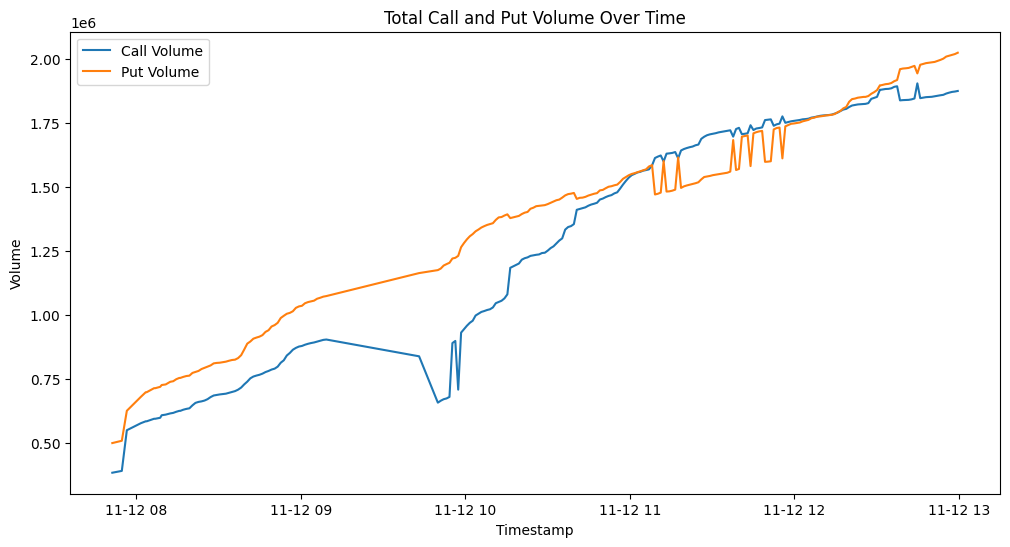

In [5]:
df['call_volume'] = call_data.apply(lambda x: sum([d['Volume'] for d in x]))
df['put_volume'] = put_data.apply(lambda x: sum([d['Volume'] for d in x]))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['call_volume'], label='Call Volume')
plt.plot(df.index, df['put_volume'], label='Put Volume')
plt.legend()
plt.title("Total Call and Put Volume Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Volume")
plt.show()